In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

## 1. Preprocessing

In [2]:
data = pd.read_csv('./data/flash_point_temperature.csv')  
data.head(3)

,iupac_name,SMILES,FPT_exp_K
0,1-acetyloxyethyl acetate,CC(=O)OC(C)OC(C)=O,339.04286
1,N-methylcyclohexanamine,CNC1CCCCC1,308.15000
2,methylsulfanylbenzene,CSc1ccccc1,345.15000


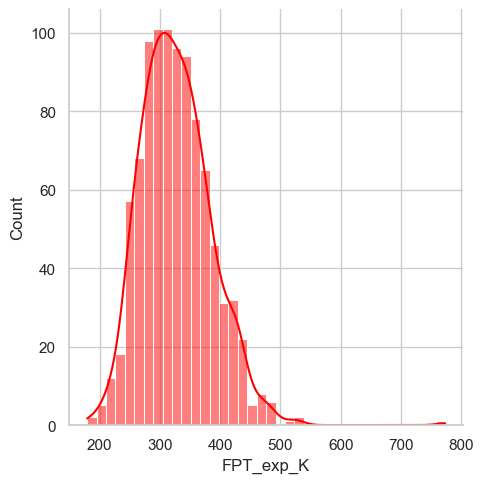

In [3]:
# distrtibution of the data
sns.displot(
    kind='hist', data=data,
    x='FPT_exp_K', 
    color='red',
    fill=True,
    kde=True
);

> Flash point temperatures higher than 550 [K] are considered as outliers.

In [4]:
data = data[data['FPT_exp_K'] < 550]
data.reset_index(drop=True, inplace=True)

## 1-1. Extracting Joback subgroups

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from thermo.group_contribution import Joback


df = pd.DataFrame(index=data.index, columns=list(data.columns)[0:3]+['MW']+list(range(1, 42)))
df.iloc[:, 0:3] = data.iloc[:, 0:3]

for index, row in df.iterrows():
    df.loc[index, 'MW'] = Descriptors.ExactMolWt(Chem.MolFromSmiles(row['SMILES']))
    df.iloc[index, 4:] = Joback(row["SMILES"]).counts

df.fillna(0, inplace=True)
df.head(2)

C:\Users\sardar\AppData\Local\Temp\ipykernel_6456\3715085832.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


,iupac_name,SMILES,FPT_exp_K,MW,1,2,3,4,5,6,...,32,33,34,35,36,37,38,39,40,41
0,1-acetyloxyethyl acetate,CC(=O)OC(C)OC(C)=O,339.04286,146.057909,3.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,N-methylcyclohexanamine,CNC1CCCCC1,308.15000,113.120449,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
X = df.iloc[:, 3:].values
y = df.loc[:, 'FPT_exp_K'].values

### 1-2. Train-Test Split (80% Train, 20% Test)

In [7]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1-3. Normalization using MinMaxScaler (-1 to 1)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




## 2. Neural Network Model

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

In [11]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(42,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

### 2-1. 5-Fold Cross-Validation

In [12]:
kf = KFold(n_splits=5)
mse_scores = []
mae_scores = []
fold = 1

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = create_model()
    
    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    fold += 1



Training fold 1
5/5 [==============================] - 0s 0s/step
Training fold 2
5/5 [==============================] - 0s 2ms/step
Training fold 3
5/5 [==============================] - 0s 2ms/step
Training fold 4
5/5 [==============================] - 0s 3ms/step
Training fold 5
5/5 [==============================] - 0s 4ms/step


### 2-2. Calculate average MSE and MAE across folds

In [13]:
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Average MSE across folds: {avg_mse}")
print(f"Average MAE across folds: {avg_mae}")

Average MSE across folds: 714.8298282304353
Average MAE across folds: 18.66516883876424


## 3. Final Evaluation on Training and Test Data


In [14]:
model = create_model()
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0);

#### 3-1. Predict on Training Data

In [15]:
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_true=y_train, y_pred=y_train_pred)

print(f"Training MSE: {train_mse}")
print(f"Training MAE: {train_mae}")

24/24 [==============================] - 0s 10ms/step
Training MSE: 570.4266612389421
Training MAE: 16.63925319289351


### 3-2. Predict on Test Data


In [16]:
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_true=y_test, y_pred=y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

6/6 [==============================] - 0s 3ms/step
Test MSE: 601.5517715643527
Test MAE: 16.418014109086148


### 3-3. Plot Real vs Predicted values and Regression Line with Seaborn

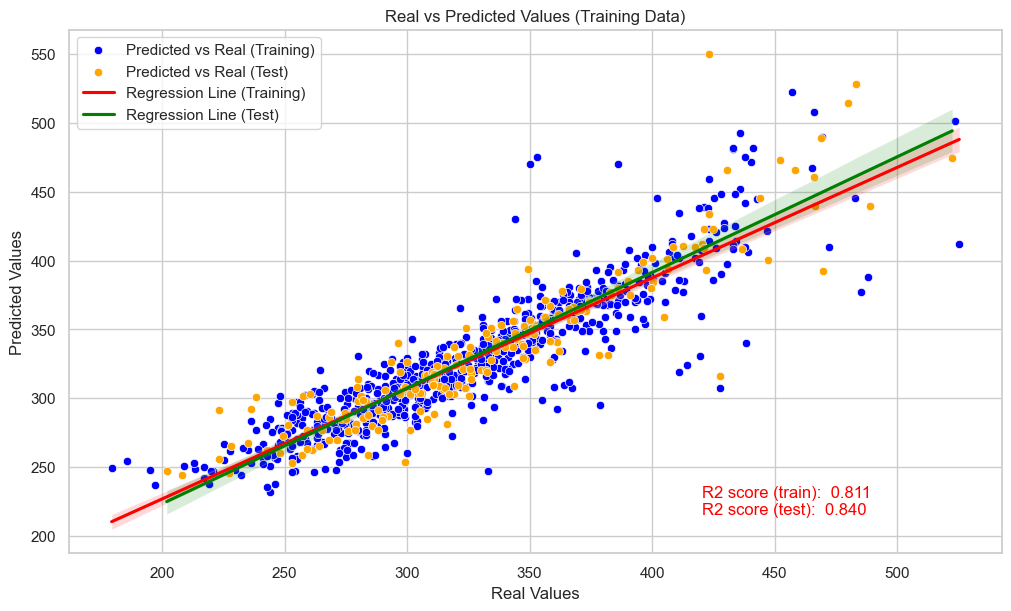

In [17]:
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

# Scatter plot for training and test data
sns.scatterplot(x=y_train, y=y_train_pred.flatten(), color='blue', label='Predicted vs Real (Training)', ax=ax)
sns.scatterplot(x=y_test, y=y_test_pred.flatten(), color='orange', label='Predicted vs Real (Test)', ax=ax)

# Draw the regression lines
sns.regplot(x=y_train, y=y_train_pred.flatten(), scatter=False, color='red', label='Regression Line (Training)',ax=ax)
sns.regplot(x=y_test, y=y_test_pred.flatten(), scatter=False, color='green', label='Regression Line (Test)', ax=ax)

ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Real vs Predicted Values (Training Data)')

text = f'R2 score (train): {r2_train: 6.3f}\nR2 score (test): {r2_test: 6.3f}'
ax.text(x=0.8*y.max(), y= 1.2*y.min(), s=text, color='red')
ax.legend()
plt.show()

In [18]:
from pathlib import Path
import joblib

models_dir = Path('models')
model_name = 'FPT_Joback.h5'
model_path = models_dir / model_name
scaler_parameters_path = models_dir / 'FPT_joback.pkl'

if models_dir.is_dir():
    if model_path.exists():
        print(f'{model_name} already exists!')
    else:
        print(f'saving {model_name} in the {models_dir} directory...')
        model.save_weights(model_path)

        # save the scaler parameters
        joblib.dump(scaler, scaler_parameters_path)
else:
    print(f'making the {models_dir} directory...')
    models_dir.mkdir()

    if model_path.exists():
        print(f'{model_name} already exists!')
    else:
        print(f'saving {model_name} in the {models_dir} directory...')
        model.save_weights(model_path)

        # save the scaler parameters
        joblib.dump(scaler, scaler_parameters_path)


making the models directory...
saving FPT_Joback.h5 in the models directory...
